In [2]:
import os
import shutil

import random

import yaml
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

## подготовка данных

In [3]:
import zipfile
from pathlib import Path

ZIP_FILES = ["velo_job14.zip", "velo_job9.zip"]  
MERGE_DIR = Path("merged_temp") 
OUTPUT_DIR = Path("data")
TRAIN_DIR  = OUTPUT_DIR / "train"
VAL_DIR    = OUTPUT_DIR / "val"
TEST_DIR   = OUTPUT_DIR / "test"
random.seed(42)

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    (d / "images").mkdir(parents=True, exist_ok=True)
    (d / "labels").mkdir(parents=True, exist_ok=True)

if MERGE_DIR.exists():
    shutil.rmtree(MERGE_DIR)
MERGE_DIR.mkdir(parents=True, exist_ok=True)

(MERGE_DIR / "images").mkdir(exist_ok=True)
(MERGE_DIR / "labels").mkdir(exist_ok=True)

for zip_path in ZIP_FILES:
    archive_prefix = Path(zip_path).stem 
    with zipfile.ZipFile(zip_path, 'r') as z:
        temp_dir = MERGE_DIR / archive_prefix
        temp_dir.mkdir(parents=True, exist_ok=True)
        z.extractall(temp_dir)

        for subfolder in ["images", "labels"]:
            src_dir = temp_dir / subfolder / "Train"
            if not src_dir.exists():
                src_dir = temp_dir / subfolder / "train"
            if not src_dir.exists():
                continue  

            for f in src_dir.iterdir():
                if f.is_file():
                    new_name = f"{archive_prefix}_{f.name}"
                    dst_path = MERGE_DIR / subfolder / new_name
                    shutil.move(f, dst_path)

IMG_DIR = MERGE_DIR / "images"
LABEL_DIR = MERGE_DIR / "labels"

image_files = [f.name for f in IMG_DIR.iterdir() if f.is_file() and f.suffix.lower() == ".png"]

images_with_labels, images_without_labels = [], []
for img in image_files:
    lbl = os.path.splitext(img)[0] + ".txt"
    if (LABEL_DIR / lbl).exists():
        images_with_labels.append(img)
    else:
        images_without_labels.append(img)

#train/val (80/20)
train_imgs, val_imgs = train_test_split(
    images_with_labels, test_size=0.2, random_state=42, shuffle=True
)

def copy_split(img_list, dst_img_dir, dst_lbl_dir):
    for img in img_list:
        lbl = os.path.splitext(img)[0] + ".txt"
        shutil.copy2(IMG_DIR / img,  dst_img_dir / img)
        shutil.copy2(LABEL_DIR / lbl, dst_lbl_dir / lbl)

copy_split(train_imgs, TRAIN_DIR / "images", TRAIN_DIR / "labels")
copy_split(val_imgs,   VAL_DIR   / "images", VAL_DIR   / "labels")

max_unlabeled = len(train_imgs)
sampled_unlabeled = random.sample(images_without_labels,
                                  min(max_unlabeled, len(images_without_labels)))

for img in sampled_unlabeled:
    shutil.copy2(IMG_DIR / img, TEST_DIR / "images" / img)

shutil.rmtree(MERGE_DIR)

print(
      f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, "
      f"Test: {len(sampled_unlabeled)}")

Train: 48, Val: 12, Test: 48


In [4]:
KPT_SHAPE = [10, 3]
FLIP_IDX  = []

data_yaml_path = os.path.join(OUTPUT_DIR, "cyclist.yaml")
data_yaml = {
    "path": str(OUTPUT_DIR),
    "train": "train/images",
    "val": "val/images",
    "nc": 1,
    "names": {0: "cyclist"},
    "kpt_shape": KPT_SHAPE,
    "flip_idx": FLIP_IDX,
}
with open(data_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

## обучение для yolo11l на 200 эпох

In [5]:
MODEL    = "yolo11l-pose.pt"  
EPOCHS   = 200
IMG_SIZE = 640
BATCH    = 8
DEVICE   = 0 #GPU


if __name__ == "__main__":
    model_l = YOLO(MODEL)
    results = model_l.train(
        data=data_yaml_path,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH,
        device=DEVICE,
        project="runs/pose_cyclist",
        name="single_split",
        exist_ok=True
    )
    print("Обучение завершено. Средние метрики:")
    print(results.mean_results())

New https://pypi.org/project/ultralytics/8.4.7 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.198 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3090 Ti, 24112MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/cyclist.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=single_split, nbs=64, nms=False

## результаты

In [6]:
metrics_values = results.mean_results()

metrics_names = [
    "Box Precision",
    "Box Recall",
    "Box mAP50",
    "Box mAP50-95",
    "Pose Precision",
    "Pose Recall",
    "Pose mAP50",
    "Pose mAP50-95"
]

print("Метрики модели YOLO11l-pose на 200 эпох:\n")
for name, value in zip(metrics_names, metrics_values):
    print(f"{name}: {value:.3f}")

Метрики модели YOLO11l-pose на 200 эпох:

Box Precision: 0.943
Box Recall: 0.998
Box mAP50: 0.986
Box mAP50-95: 0.792
Pose Precision: 0.924
Pose Recall: 0.979
Pose mAP50: 0.970
Pose mAP50-95: 0.702


## Визуализация


image 1/1 /home/natalyasklyar/velo/data/val/images/velo_job9_vlcsnap-2025-05-03-13h44m13s419.png: 384x640 4 cyclists, 56.9ms
Speed: 1.1ms preprocess, 56.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


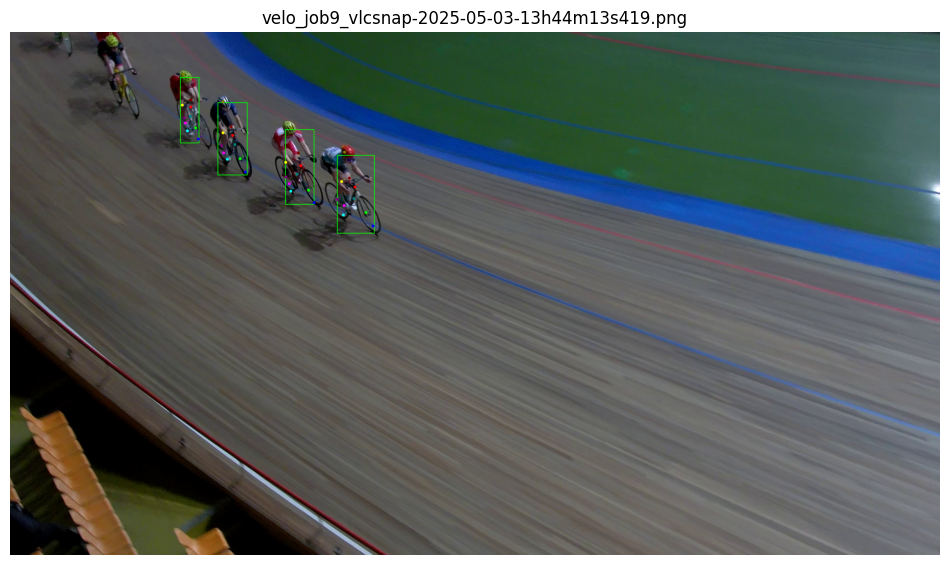


image 1/1 /home/natalyasklyar/velo/data/val/images/velo_job9_vlcsnap-2025-05-03-13h37m18s974.png: 384x640 1 cyclist, 11.6ms
Speed: 1.1ms preprocess, 11.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


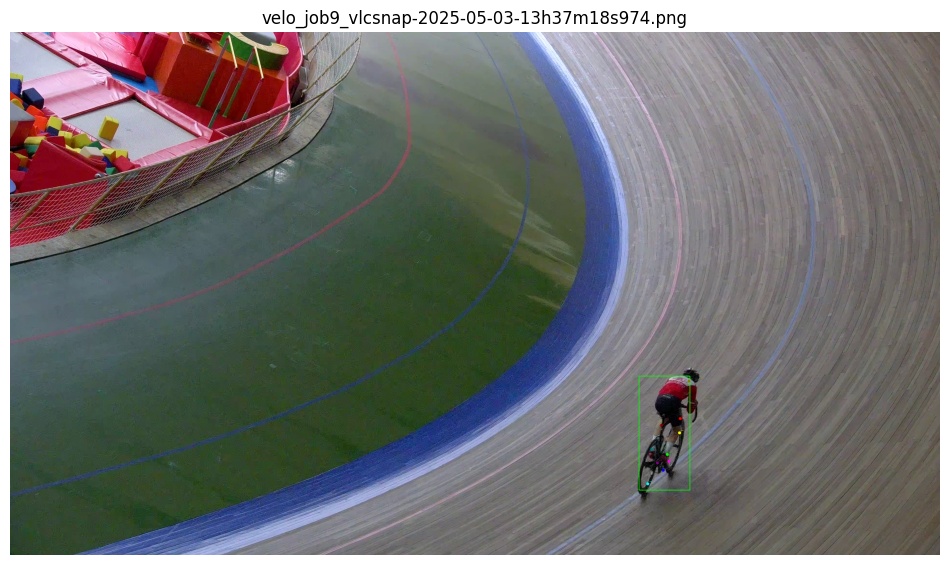


image 1/1 /home/natalyasklyar/velo/data/val/images/velo_job9_vlcsnap-2025-05-03-13h45m45s758.png: 384x640 5 cyclists, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


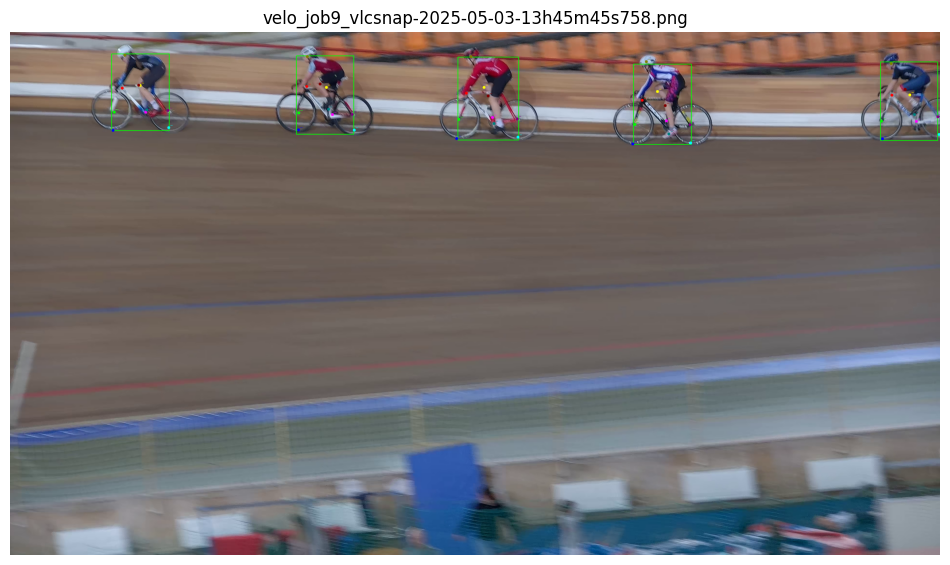


image 1/1 /home/natalyasklyar/velo/data/val/images/velo_job9_vlcsnap-2025-05-03-13h34m20s945.png: 384x640 2 cyclists, 12.1ms
Speed: 1.3ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


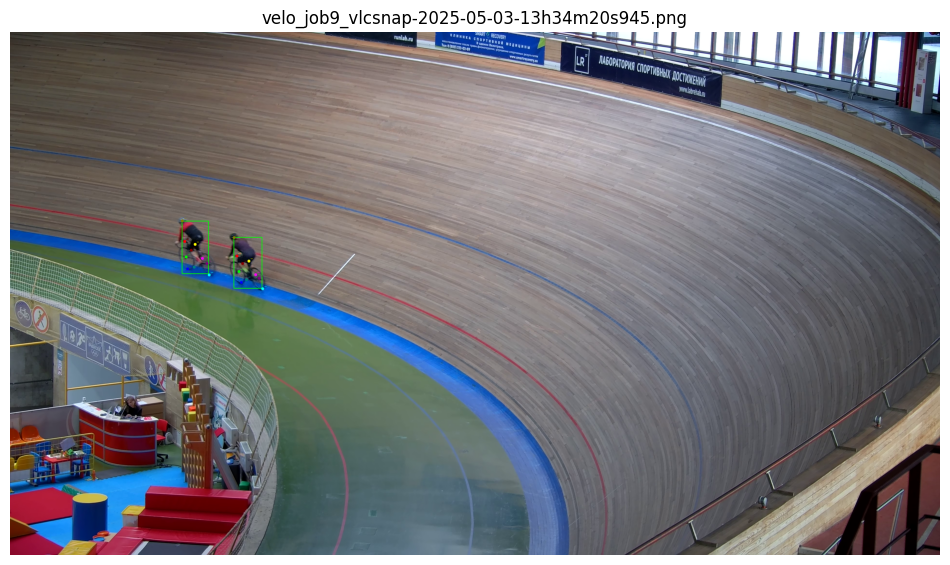


image 1/1 /home/natalyasklyar/velo/data/val/images/velo_job9_vlcsnap-2025-05-03-13h37m52s613.png: 384x640 1 cyclist, 12.9ms
Speed: 1.2ms preprocess, 12.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


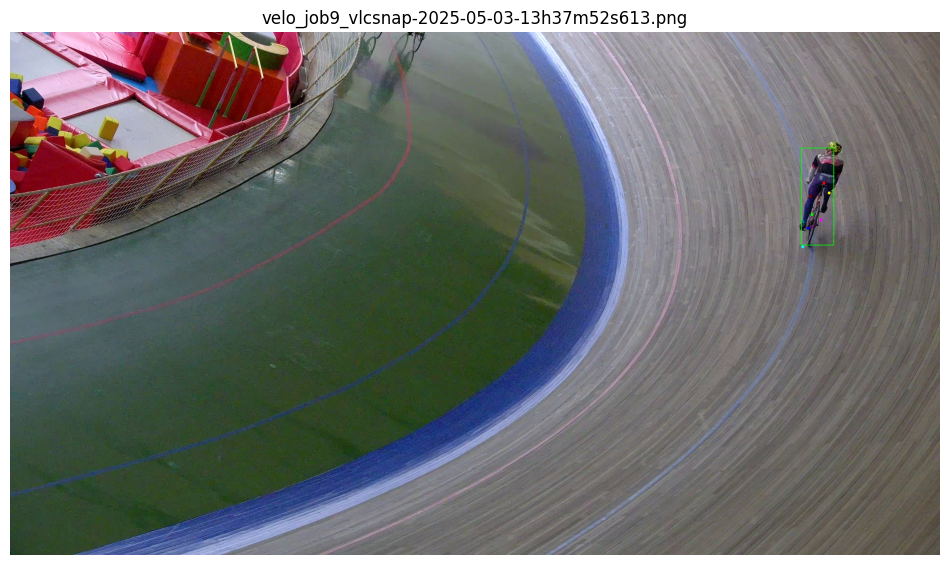

In [8]:
%matplotlib inline
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO


MODEL_PATH = "runs/pose_cyclist/single_split/weights/best.pt"
TEST_IMAGES_DIR = "data/val/images"


model = model_l

test_images = [os.path.join(TEST_IMAGES_DIR, f) 
               for f in os.listdir(TEST_IMAGES_DIR) 
               if f.lower().endswith((".png"))]

# Названия 10 ключевых точек (пример)
keypoint_names = [
    "-", "-", "-", "-", "-",
    "-", "-", "-", "-", "-"
]

# Цвета для каждой точки (BGR)
keypoint_colors = [
    (255, 0, 0),    # синий
    (0, 255, 0),    # зелёный
    (0, 0, 255),    # красный
    (255, 255, 0),  # голубой
    (255, 0, 255),  # пурпурный
    (0, 255, 255),  # жёлтый
    (128, 0, 128),  # фиолетовый
    (128, 128, 0),  # оливковый
    (0, 128, 128),  # тёмно-циан
    (128, 0, 0)     # бордовый
]

N = 5  # сколько изображений показать
for img_path in test_images[:N]:
    results = model.predict(source=img_path, save=False, conf=0.25, show=False)
    result = results[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Bounding boxes
    for box in result.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Keypoints
    for kpts in result.keypoints:
        xy = kpts.xy.cpu().numpy()
        conf = kpts.conf.cpu().numpy()
        for det_xy, det_conf in zip(xy, conf):
            for idx, ((x, y), c) in enumerate(zip(det_xy, det_conf)):
                if c > 0.3:  # отображаем только уверенные точки
                    color = keypoint_colors[idx % len(keypoint_colors)]
                    cv2.circle(img, (int(x), int(y)), 6, color, -1)  # увеличенный радиус
                    # подпись точки
                    cv2.putText(img, keypoint_names[idx % len(keypoint_names)],
                                (int(x)+5, int(y)-5), cv2.FONT_HERSHEY_SIMPLEX,
                                0.5, color, 1, cv2.LINE_AA)

    # Отображаем изображение в Jupyter
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(img_path))
    plt.show()


image 1/1 /home/natalyasklyar/velo/data/test/images/velo_job9_vlcsnap-2025-05-03-14h23m33s721.png: 384x640 2 cyclists, 11.8ms
Speed: 14.4ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


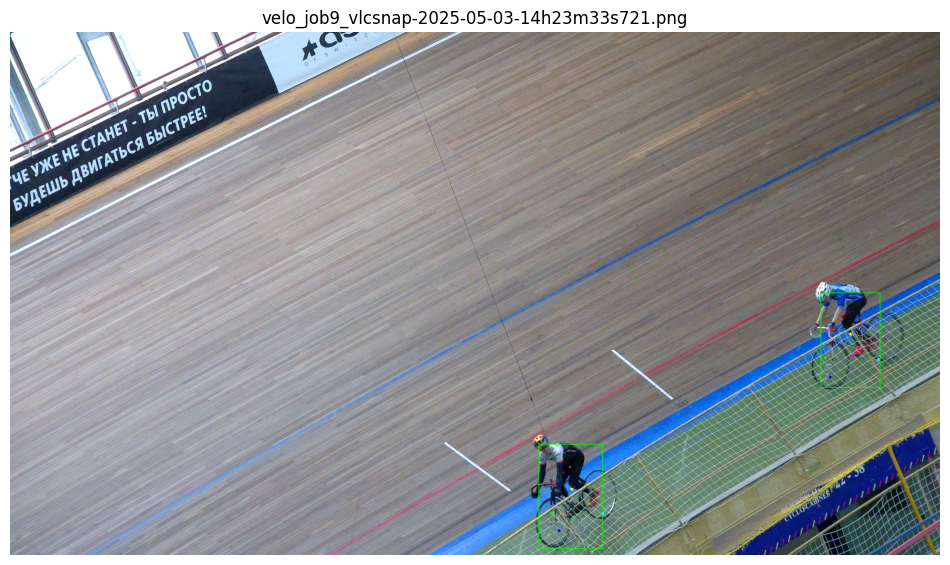


image 1/1 /home/natalyasklyar/velo/data/test/images/velo_job14_vlcsnap-2025-05-04-17h37m30s684.png: 384x640 1 cyclist, 12.0ms
Speed: 1.2ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


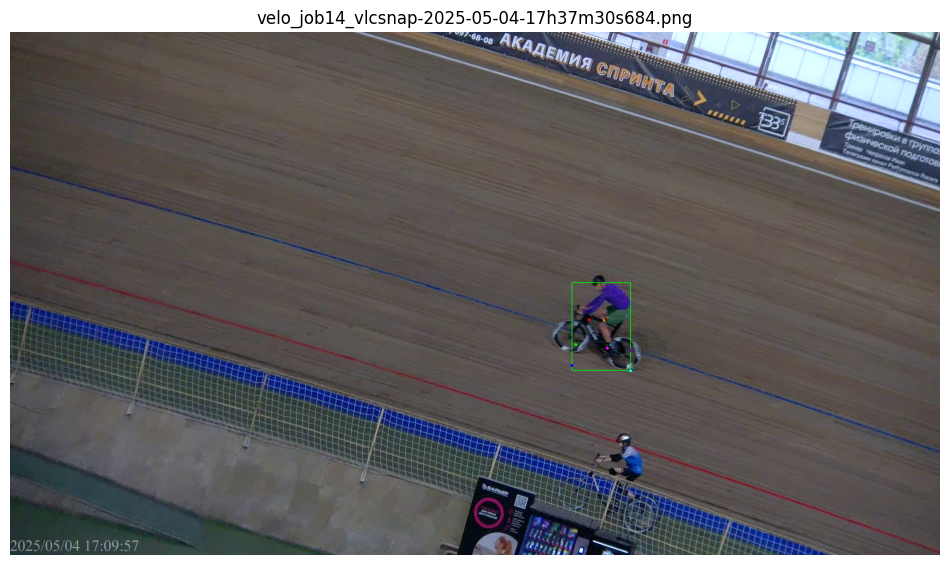


image 1/1 /home/natalyasklyar/velo/data/test/images/velo_job9_vlcsnap-2025-05-03-13h50m12s773.png: 384x640 1 cyclist, 11.9ms
Speed: 1.2ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


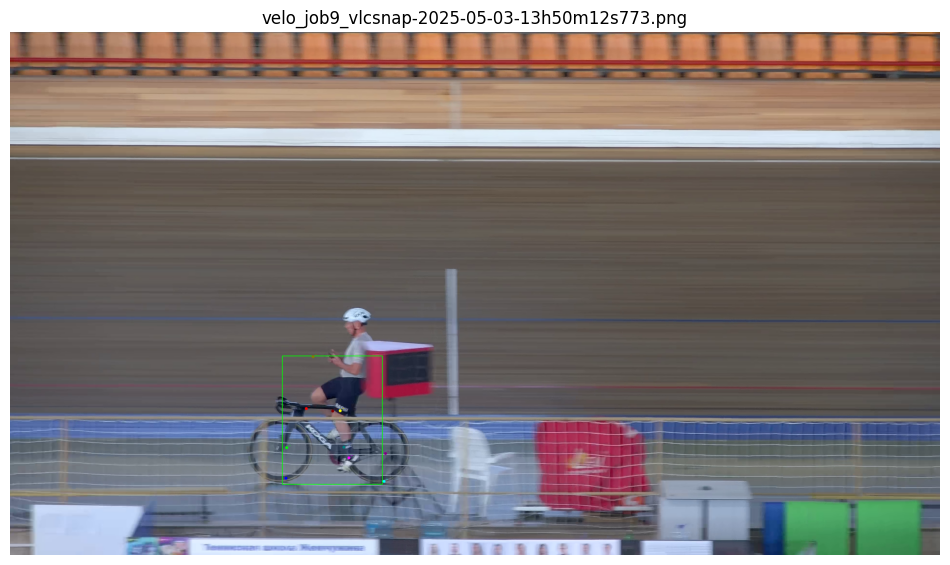


image 1/1 /home/natalyasklyar/velo/data/test/images/velo_job9_vlcsnap-2025-05-03-13h58m26s696.png: 384x640 2 cyclists, 11.9ms
Speed: 1.1ms preprocess, 11.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


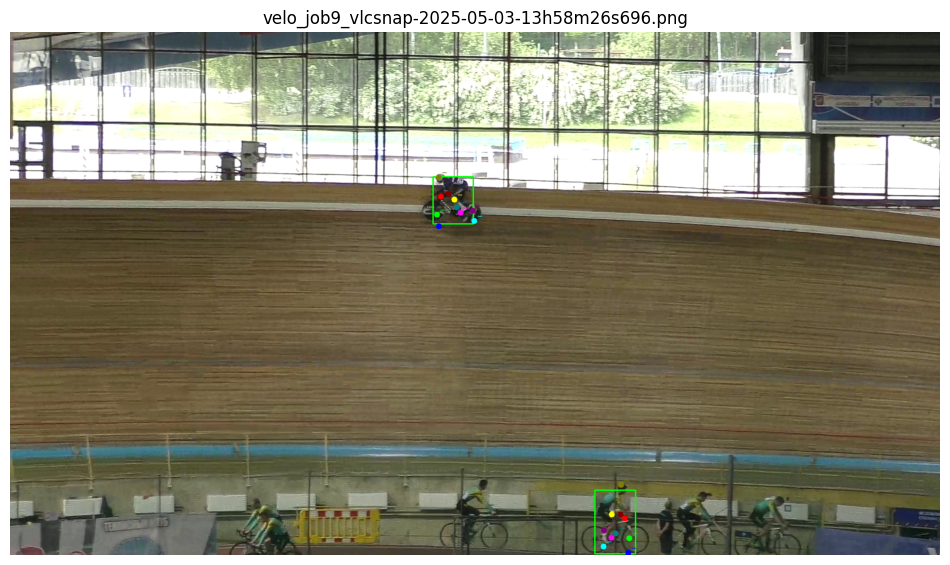


image 1/1 /home/natalyasklyar/velo/data/test/images/velo_job9_vlcsnap-2025-05-03-14h04m31s641.png: 384x640 1 cyclist, 12.0ms
Speed: 1.1ms preprocess, 12.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


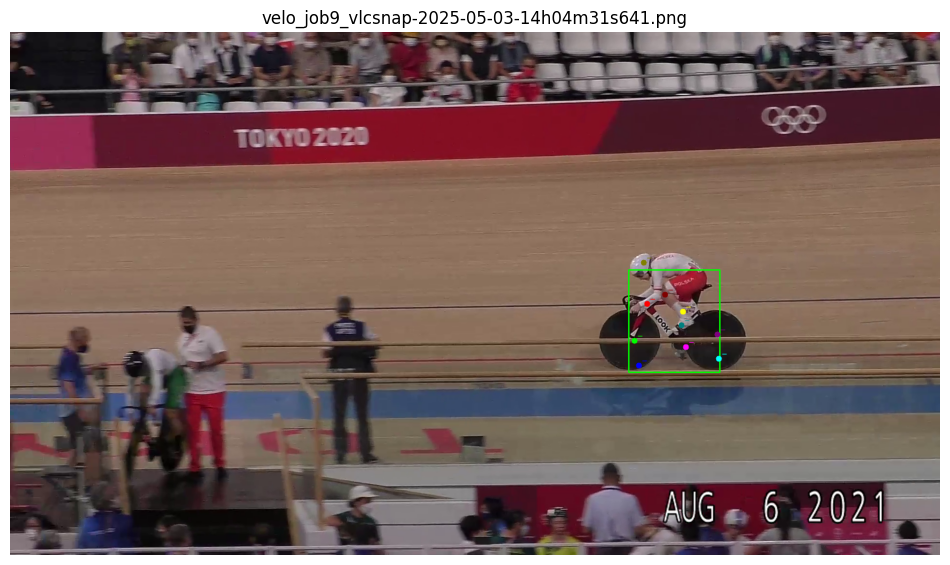

In [10]:

TEST_IMAGES_DIR_2 = "data/test/images"

test_images_2 = [os.path.join(TEST_IMAGES_DIR_2, f) 
                 for f in os.listdir(TEST_IMAGES_DIR_2) 
                 if f.lower().endswith((".png"))]


N = 5
for img_path in test_images_2[:N]:
    results = model.predict(source=img_path, save=False, conf=0.25, show=False)
    result = results[0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in result.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for kpts in result.keypoints:
        xy = kpts.xy.cpu().numpy()
        conf = kpts.conf.cpu().numpy()
        for det_xy, det_conf in zip(xy, conf):
            for idx, ((x, y), c) in enumerate(zip(det_xy, det_conf)):
                if c > 0.3:
                    color = keypoint_colors[idx % len(keypoint_colors)]
                    cv2.circle(img, (int(x), int(y)), 6, color, -1)
                    cv2.putText(img, keypoint_names[idx % len(keypoint_names)],
                                (int(x)+5, int(y)-5), cv2.FONT_HERSHEY_SIMPLEX,
                                0.5, color, 1, cv2.LINE_AA)

    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(img_path))
    plt.show()